# Imports

In [4]:
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn import metrics
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import mlflow
import utils
from sklearn.model_selection import train_test_split, StratifiedKFold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator





from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler



PATH = '/Users/mimi/Desktop/PYTHON/TURING/HOME/MachLearning/S2/data/archive (1).zip'

df = pd.read_csv(PATH)
df.drop(columns='id', inplace=True)
df_ = df.copy()
df.drop(df[df.gender == 'Other'].index,inplace=True)
df.reset_index(drop=True,inplace=True)





df.head()



,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Training

## All of them

In [1]:
import operator

cv = 5
stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
X = df.drop(columns='stroke')
y = df['stroke']

clfs = {
    "SVC": SVC(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(verbosity=0, use_label_encoder=False),
    "LightGBM": lgbm.LGBMClassifier(),
    "Catboost": CatBoostClassifier(verbose=False),
}


models = {}  

mean_fpr = np.linspace(0, 1, 100)

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score

results_list = []
for clf_name, clf in clfs.items():
    fold_auc_scores = []
    fold_precision_scores = []
    fold_recall_scores = []
    fold_f1_scores = []
    tprs = []
    aucs = []
    conf_mats = []  

    for train_index, test_index in stratified_kfold.split(X, y):
        X_train, X_test = utils.preprocess_data(X.iloc[train_index]), utils.preprocess_data(X.iloc[test_index])
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        auc_score = roc_auc_score(y_test, y_pred_proba)
        fold_auc_scores.append(auc_score)
        
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        fold_precision_scores.append(precision_score(y_test, clf.predict(X_test)))
        fold_recall_scores.append(recall_score(y_test, clf.predict(X_test)))
        fold_f1_scores.append(f1_score(y_test, clf.predict(X_test)))
        
        y_pred = clf.predict(X_test)
        conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
        conf_mats.append(conf_mat)

    mean_auc_score = np.mean(fold_auc_scores)
    std_auc_score = np.std(fold_auc_scores)
    mean_tpr = np.mean(tprs, axis=0)
    mean_roc_auc = auc(mean_fpr, mean_tpr)
    mean_precision = np.mean(fold_precision_scores)
    mean_recall = np.mean(fold_recall_scores)
    mean_f1 = np.mean(fold_f1_scores)
    mean_conf_mat = np.mean(conf_mats, axis=0)  

    models[clf_name] = clf

    results_list.append({'Classifier': clf_name, 
                         'Mean AUC': mean_auc_score, 
                         'Std AUC': std_auc_score,
                         'Mean Precision': mean_precision,
                         'Mean Recall': mean_recall,
                         'Mean F1': mean_f1,
                         'Mean TPR': mean_tpr, 
                         'Mean ROC AUC': mean_roc_auc, 
                         'Mean Confusion Matrix': mean_conf_mat})

results_df = pd.DataFrame(results_list)

sorted_results_df = results_df.sort_values(by='Mean AUC', ascending=False)

top_3_models_df = sorted_results_df.head(3)

plt.figure(figsize=(10, 6))
for _, row in top_3_models_df.iterrows():
    clf_name = row['Classifier']
    mean_auc = row['Mean AUC']
    std_auc = row['Std AUC']
    mean_tpr = row['Mean TPR']
    mean_roc_auc = row['Mean ROC AUC']
    
    plt.plot(mean_fpr, mean_tpr, label=f"{clf_name}, AUC = {mean_roc_auc:.2f} (CV Mean = {mean_auc:.2f} ± {std_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
sns.despine()
plt.show()


NameError: name 'StratifiedKFold' is not defined

In [6]:
top_3_models_df

,Classifier,Mean AUC,Std AUC,Mean Precision,Mean Recall,Mean F1,Mean TPR,Mean ROC AUC,Mean Confusion Matrix
7,gbc,0.839402,0.014290,0.12,0.012082,0.021953,"[0.0, 0.06824489795918368, 0.12440816326530613...",0.839502,"[[968.8, 3.2], [49.2, 0.6]]"
8,lr,0.837189,0.021146,0.00,0.000000,0.000000,"[0.012, 0.06416326530612246, 0.116244897959183...",0.837208,"[[971.8, 0.2], [49.8, 0.0]]"
4,ada,0.825906,0.015965,0.20,0.012000,0.022382,"[0.0, 0.052163265306122454, 0.1243265306122449...",0.825901,"[[970.2, 1.8], [49.2, 0.6]]"


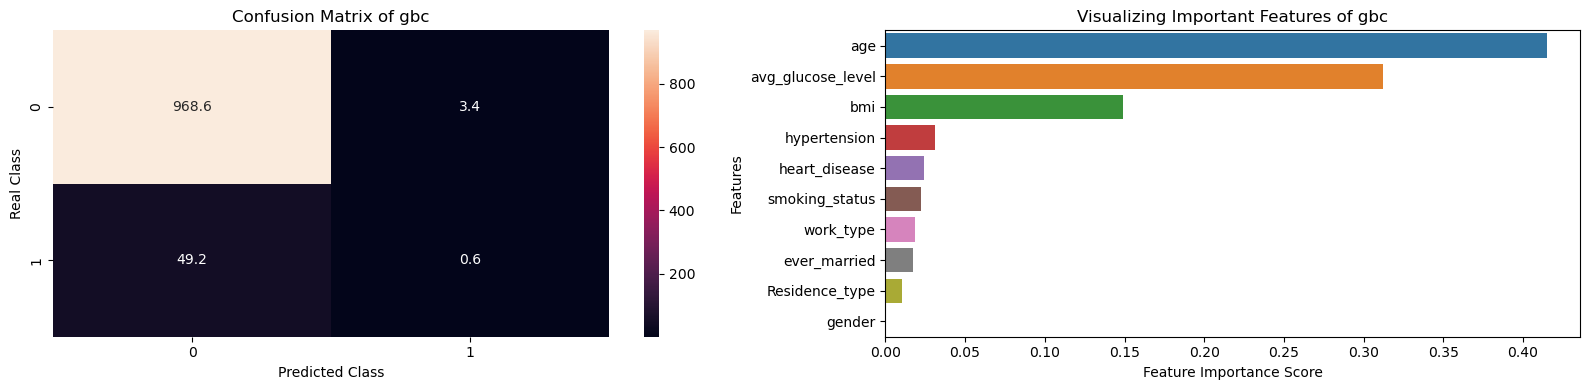

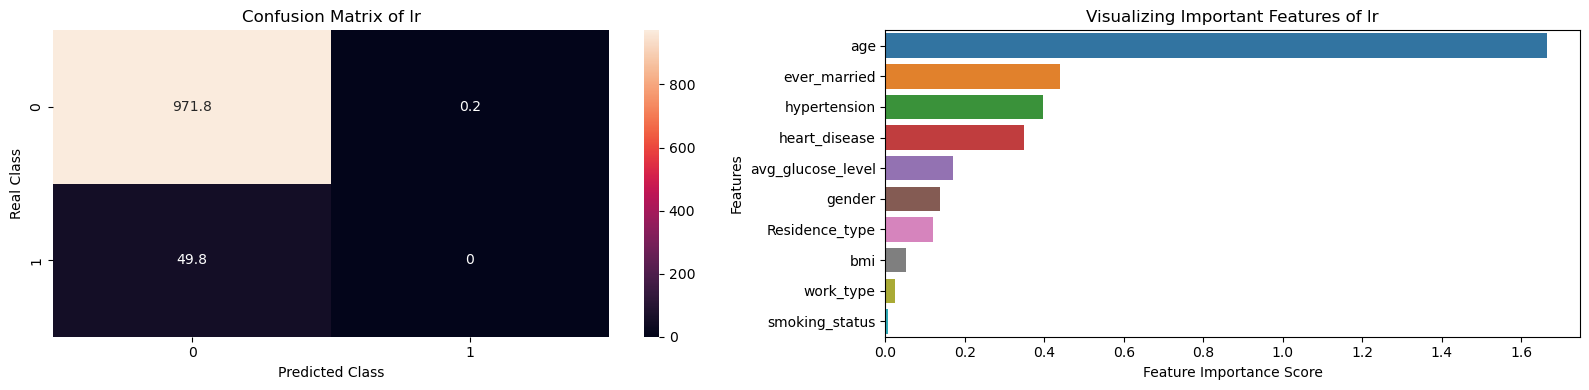

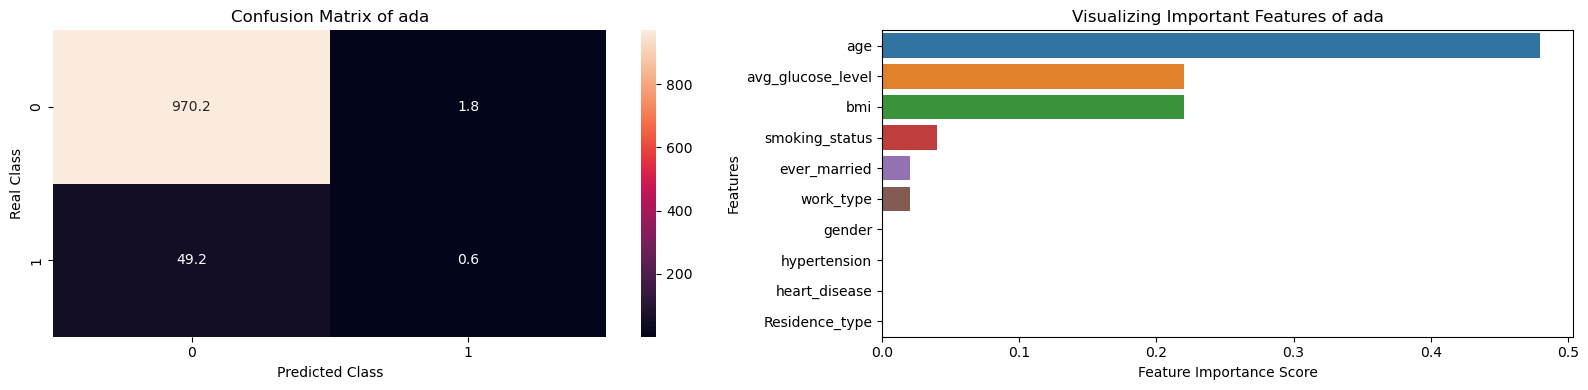

In [5]:
def plot_top_models(top_models_df, models, X_train):
    for _, row in top_models_df.iterrows():
        clf_name = row['Classifier']
        mean_conf_mat = row['Mean Confusion Matrix']

        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

        
        sns.heatmap(mean_conf_mat, annot=True, fmt='g', ax=axes[0])
        axes[0].set_title(f'Confusion Matrix of {clf_name}')
        axes[0].set_ylabel('Real Class')
        axes[0].set_xlabel('Predicted Class')

        
        clf_model = models[clf_name]
        if hasattr(clf_model, 'feature_importances_'):
            feature_importance = clf_model.feature_importances_
            feature_scores = pd.Series(feature_importance, index=X_train.columns).sort_values(ascending=False)
            sns.barplot(x=feature_scores, y=feature_scores.index, ax=axes[1])
            axes[1].set_xlabel('Feature Importance Score')
            axes[1].set_ylabel('Features')
            axes[1].set_title(f"Visualizing Important Features of {clf_name}")
        elif clf_name == 'lr':  
            coefficients = models['lr'].coef_[0]
            imp_df = pd.DataFrame({"Feature Name": X_train.columns, "Importance": np.abs(coefficients)})
            features = imp_df.sort_values(by="Importance", ascending=False)
            sns.barplot(x=features["Importance"], y=features["Feature Name"], ax=axes[1])
            axes[1].set_xlabel('Feature Importance Score')
            axes[1].set_ylabel('Features')
            axes[1].set_title(f"Visualizing Important Features of {clf_name}")

        plt.tight_layout()
        plt.show()


plot_top_models(top_3_models_df, models, X_train)

## GradientBoostingClassifier

In [ ]:
def objective(trial, X, y, cv, scoring):
  """
  An objective function to tune hyperparameters of Gradient Boosting Classifier.
  Args:
    trial: an Optuna trial
    X: DataFrame object, features
    y: Series object, Labels
    cv: k folds to cross-validate
    scoring: String, evaluation metric
  Return:
    Mean test accuracy
  """

  params = {
    "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step = 100),
    "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log = True),
    "max_depth": trial.suggest_int("max_depth", 3, 9),
    "subsample": trial.suggest_float("subsample", 0.5, 0.9, step = 0.1),
    "max_features": trial.suggest_categorical("max_features", [ "sqrt", "log2"]),
    "random_state": 42,
    }
  # Perform cross validation
  gb_class = GradientBoostingClassifier(**params)

  # Compute scores
  scores = cross_validate(gb_class, X, y, cv = cv, scoring = scoring, n_jobs = -1)
  accuracy = scores["test_score"].mean()

  return accuracy

In [ ]:
study = optuna.create_study(direction = "maximize")


func = lambda trial: objective(trial, X_train_processed, y_train, cv = stratified_kfold, scoring = "roc_auc")

In [ ]:
%%time
# Start optimizing with 100 trials
study.optimize(func, n_trials = 50)

In [ ]:
print(f"The highest accuracy reached by this study: {(study.best_value) * 100}%.")


In [ ]:
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")


In [ ]:
auc_params = study.best_params

In [ ]:
tuna_gbc = GradientBoostingClassifier(**auc_params)

tuna_gbc.fit(X_train_processed, y_train)
y_pred_probas_tuna_gbc = tuna_gbc.predict_proba(X_test_processed)[:, 1]
tune_score = roc_auc_score(y_test, y_pred_probas_tuna_gbc)





In [ ]:

tuna_gbc = GradientBoostingClassifier(**auc_params)

tuna_gbc.fit(X_train_processed, y_train)
y_pred_probas_tuna_gbc = tuna_gbc.predict_proba(X_test_processed)[:, 1]
tune_score = roc_auc_score(y_test, y_pred_probas_tuna_gbc)






conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_probas_tuna_gbc)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas_tuna_gbc)
roc_auc = auc(fpr, tpr)

# Plot confusion matrix and ROC curve side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='g', ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14)
axes[0].set_ylabel('Real Class', fontsize=12)
axes[0].set_xlabel('Predicted Class', fontsize=12)

# Plot ROC curve with exact AUC score in the title
axes[1].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'Receiver Operating Characteristic (ROC) Curve (AUC = {roc_auc:.2f})')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
tune_score = roc_auc_score(y_test, y_pred_probas_tuna_gbc)

In [ ]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_tuna_gbc)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas_tuna_gbc)
roc_auc = auc(fpr, tpr)

# Plot confusion matrix and ROC curve side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='g', ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14)
axes[0].set_ylabel('Real Class', fontsize=12)
axes[0].set_xlabel('Predicted Class', fontsize=12)

# Plot ROC curve
axes[1].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

##  Log Regression

## ADA